# Goal

In this project, we need to find out commercial products listed on Google that refer to the same entity across Amazon by comparing the similarity. This problem is called **Entity Resolution**.

This notebook will demonstrate how we can use Apache Spark to do following things: 
* Applied powerful and scalable text analysis techniques.
* Perform entity resolution across two datasets of commercial products.
* Discussed the use scenario of **Broadcast Variable**.
* Implemented a scalable ER algorithm.

# What is Entity Resolution

Entity Resolution (ER) refers to the task of finding records in a dataset that refer to the same entity across different data sources (e.g., data files, books, websites, databases). ER is necessary when joining datasets based on entities that may or may not share a common identifier (e.g., database key, URI, National identification number), as may be the case due to differences in record shape, storage location, and/or curator style or preference. A dataset that has undergone ER may be referred to as being cross-linked.

# Summary of Data Set

* Google.csv, the commercial products dataset from Google.
* Amazon.csv, the commercial products dataset from Amazon.
* Amazon_Google_perfectMapping.csv, the identifiers mapping of products between Google and Amazon. 
* stopwords.txt, a list of common English words

[Link of data set](https://code.google.com/archive/p/metric-learning/source/default/source)

# Load Data

Omitting the headers, we load these data files into pair RDDs where the mapping ID is the key, and the value is a string consisting of the name/title, description, and manufacturer from the record.

* The file format of an Amazon line is: ["id","title","description","manufacturer","price"]
* The file format of a Google line is: ["id","name","description","manufacturer","price"]

In [2]:
import re
DATAFILE_PATTERN = '^(.+),"(.+)",(.*),(.*),(.*)'
dir_path = "data/"

def removeQuotes(s):
    """
    Remove quotation marks from an input string
    """
    return ''.join(i for i in s if i!='"')

def parseDatafileLine(datafileLine):
    """
    Parse a line of the data file using the specified regular expression pattern
    """
    match = re.search(DATAFILE_PATTERN, datafileLine)
    if match is None:
        print 'Invalid datafile line: {}'.format(datafileLine)
        return (datafileLine, -1)
    elif match.group(1) == '"id"':
        print 'Header datafile line: {}'.format(datafileLine)
        return (datafileLine, 0)
    else:
        product = '{} {} {}'.format(match.group(2), match.group(3), match.group(4))
        return ((removeQuotes(match.group(1)), product), 1)
    
def parseData(filename):
    """
    Parse a data file
    """
    return (sc
            .textFile(filename, 4, 0)
            .map(parseDatafileLine))

def loadData(filename):
    """
    Load a data file
    """
    raw = parseData(dir_path+filename).cache()
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print '{} - Invalid datafile line: {}'.format(path, line)
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    print '{} - Read {} lines, successfully parsed {} lines, failed to parse {} lines'.format(filename,
                                                                                        raw.count(),
                                                                                        valid.count(),
                                                                                        failed.count())
    assert failed.count() == 0
    assert raw.count() == (valid.count() + 1)
    return valid

google = loadData("Google.csv")
amazon = loadData("Amazon.csv")

Google.csv - Read 3227 lines, successfully parsed 3226 lines, failed to parse 0 lines
Amazon.csv - Read 1364 lines, successfully parsed 1363 lines, failed to parse 0 lines


In [3]:
for line in google.take(3):
    print 'Google: {}: {}\n'.format(line[0], line[1])

for line in amazon.take(3):
    print 'Amazon: {}: {}\n'.format(line[0], line[1])

Google: http://www.google.com/base/feeds/snippets/11125907881740407428: learning quickbooks 2007 "learning quickbooks 2007" "intuit"

Google: http://www.google.com/base/feeds/snippets/11538923464407758599: superstart! fun with reading & writing! "fun with reading & writing! is designed to help kids learn to read and write better through exercises puzzle-solving creative writing decoding and more!" 

Google: http://www.google.com/base/feeds/snippets/11343515411965421256: qb pos 6.0 basic software "qb pos 6.0 basic retail mngmt software. for retailers who need basic inventory sales and customer tracking." "intuit"

Amazon: b000jz4hqo: clickart 950 000 - premier image pack (dvd-rom)  "broderbund"

Amazon: b0006zf55o: ca international - arcserve lap/desktop oem 30pk "oem arcserve backup v11.1 win 30u for laptops and desktops" "computer associates"

Amazon: b00004tkvy: noah's ark activity center (jewel case ages 3-8)  "victory multimedia"



# ER as Text Similarity - Bag of Words

A simple approach to in this problem is to treat all records as strings and compute their similarity with a string distance function. [Bag-of-words][bag-of-words] is a conceptually simple yet powerful approach to text analysis.

[bag-of-words]: https://en.wikipedia.org/wiki/Bag-of-words_model

## Remove stopwords

Stopwords are common words that do not contribute much to the content or meaning of a document (e.g., "the", "a", "is", "to", etc.). Stopwords add noise to bag-of-words comparisons, so they are usually excluded.

In [4]:
stopwords = set(sc.textFile(dir_path+"stopwords.csv").collect())
print 'These are the stopwords: {}'.format(stopwords)

These are the stopwords: set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'with', u'had', u'should', u'to', u'only', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'stopword', u'they', u'not', u'during', u'now', u'him', u'nor', u'did', u'these', u't', u'each', u'where', u'because', u'doing', u'theirs', u'some', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'below', u'does', u'above', u'between', u'she', u'be', u'we', u'after', u'here', u'hers', u'by', u'on', u'about', u'of', u'against', u's', u'or', u'own', u'into', u'yourself', u'down', u'your', u'from', u'her', u'whom', u'there', u'been', u'few', u'too', u'themselves', u'was', u'until', u'more', u'himself', u'that', u'but', u'off', u'herself', u'than', u'those', u'he', u'me', u'myself', u'this', u'up', u'will', u'while', u'can', u'were', u'my', u'and', u'then', u'is', u'in', u'am', u'it', u'an', u'as', u'itself', u'at', u'have', u'further', u'their', u'if', u'aga

## Tokenizing the datasets

In [5]:
def tokenize(string):
    """ 
    An implementation of input string tokenization that excludes stopwords
    """
    return [w for w in re.sub(r'\W+', ' ', string).strip().lower().split() if w not in stopwords]


amazonRecToToken = amazon.map(lambda pair: (pair[0], tokenize(pair[1])))
googleRecToToken = google.map(lambda pair: (pair[0], tokenize(pair[1])))

In [6]:
from operator import add

def countTokens(vendorRDD):
    """ 
    Count and return the number of tokens
    """
    return vendorRDD.map(lambda pair: len(pair[1])).reduce(add)

print 'There are {} tokens in the combined datasets'.format(countTokens(amazonRecToToken) + countTokens(googleRecToToken))

There are 297373 tokens in the combined datasets


In [7]:
def findBiggestRecord(vendorRDD):
    """ 
    Find and return the record with the largest number of tokens
    """
    return vendorRDD.takeOrdered(1, key=lambda pair: -len(pair[1]))

biggestRecordAmazon = findBiggestRecord(amazonRecToToken)
print 'The Amazon record with ID "{}" has the most tokens, {}.'.format(biggestRecordAmazon[0][0], 
                                                                       len(biggestRecordAmazon[0][1]))
biggestRecordGoogle = findBiggestRecord(googleRecToToken)
print 'The Google record with ID "{}" has the most tokens, {}.'.format(biggestRecordGoogle[0][0], 
                                                                       len(biggestRecordGoogle[0][1]))

The Amazon record with ID "b000ndibqy" has the most tokens, 2057.
The Google record with ID "http://www.google.com/base/feeds/snippets/7704167897291051109" has the most tokens, 61.


# ER as Text Similarity - Weighted Bag-of-Words using TF-IDF

Bag-of-words comparisons are not very good when all tokens are treated the same: some tokens are more important than others. Weights give us a way to specify which tokens to favor.

* TF
    * TF rewards tokens that appear many times in the same document. It is computed as the frequency of a token in a document, that is, if document d contains 100 tokens and token t appears in d 5 times, then the TF weight of t in d is 5/100 = 1/20. The intuition for TF is that if a word occurs often in a document, then it is more important to the meaning of the document.
* IDF
    * IDF rewards tokens that are rare overall in a dataset. The intuition is that it is more significant if two documents share a rare word than a common one. IDF weight for a token, t, in a set of documents, U, is computed as follows:
        * Let N be the total number of documents in U
        * Find n(t), the number of documents in U that contain t
        * Then IDF(t) = N/n(t).

## Create a corpus

In [8]:
corpusRDD = googleRecToToken.union(amazonRecToToken)

In [9]:
for i in corpusRDD.take(5):
    print(i)

('http://www.google.com/base/feeds/snippets/11125907881740407428', ['learning', 'quickbooks', '2007', 'learning', 'quickbooks', '2007', 'intuit'])
('http://www.google.com/base/feeds/snippets/11538923464407758599', ['superstart', 'fun', 'reading', 'writing', 'fun', 'reading', 'writing', 'designed', 'help', 'kids', 'learn', 'read', 'write', 'better', 'exercises', 'puzzle', 'solving', 'creative', 'writing', 'decoding'])
('http://www.google.com/base/feeds/snippets/11343515411965421256', ['qb', 'pos', '6', '0', 'basic', 'software', 'qb', 'pos', '6', '0', 'basic', 'retail', 'mngmt', 'software', 'retailers', 'need', 'basic', 'inventory', 'sales', 'customer', 'tracking', 'intuit'])
('http://www.google.com/base/feeds/snippets/12049235575237146821', ['math', 'missions', 'amazing', 'arcade', 'adventure', 'grades', '3', '5', 'save', 'spectacle', 'city', 'disrupting', 'randall', 'underling', 'plan', 'drive', 'stores', 'business', 'take', 'city', 'solve', 'real', 'world', 'math', 'challenges', 'uniq

## TF

In [10]:
def tf(tokens):
    """ 
    Compute TF
    """
    TF = {}
    unit = 1.0/len(tokens)
    for token in tokens:
        if token in TF:
            TF[token] += unit
        else:
            TF[token] = unit
    return TF

## IDF

In [11]:
def idfs(corpus):
    """ 
    Compute IDF
    """
    uniqueTokens = corpus.flatMap(lambda pair: set(pair[1]))
    tokenCountPairTuple = uniqueTokens.map(lambda token: (token, 1.0))
    tokenSumPairTuple = tokenCountPairTuple.reduceByKey(add)
    N = corpus.count()
    return (tokenSumPairTuple.map(lambda pair: (pair[0], N/pair[1])))

idfsFull = idfs(amazonRecToToken.union(googleRecToToken))
print 'There are {} unique tokens in the datasets.'.format(idfsFull.count())

There are 17078 unique tokens in the datasets.


In [12]:
# Top 5 idfs
idfsFull.takeOrdered(5, lambda s: -s[1])

[('paperless', 4589.0),
 ('promenade', 4589.0),
 ('presentationsimply', 4589.0),
 ('fawn', 4589.0),
 ('believed', 4589.0)]

In [13]:
# Bottom 5 idfs
idfsFull.takeOrdered(5, lambda s: s[1])

[('software', 2.472521551724138),
 ('mac', 5.616891064871481),
 ('1', 5.816223067173637),
 ('windows', 6.3647711511789185),
 ('system', 6.748529411764705)]

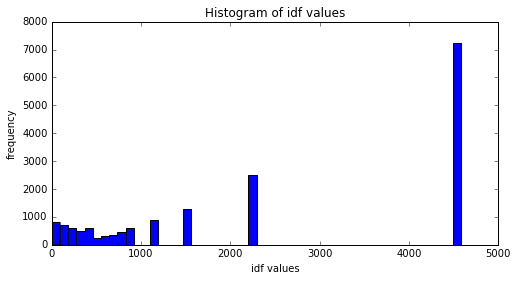

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

idf_values = idfsFull.map(lambda pair: pair[1]).collect()
fig = plt.figure(figsize=(8, 4))
plt.hist(idf_values, 50)
plt.title("Histogram of idf values")
plt.xlabel("idf values")
plt.ylabel("frequency")

## TF-IDF

In [15]:
def tfidf(tokens, idfs):
    """ 
    Compute TF-IDF
    """
    tfs = tf(tokens)
    tfIdfDict = dict((token, tfs[token]*idfs[token]) for token in tokens)
    return tfIdfDict

In [16]:
recb000hkgj8k_tokens = amazonRecToToken.filter(lambda x: x[0] == 'b000hkgj8k').collect()[0][1]
idfsWeights = idfsFull.collectAsMap()
recb000hkgj8k_tfidf = tfidf(recb000hkgj8k_tokens, idfsWeights)

recb000jz4hqo_tokens = amazonRecToToken.filter(lambda x: x[0] == 'b000jz4hqo').collect()[0][1]
recb000jz4hqo_tfidf = tfidf(recb000jz4hqo_tokens, idfsWeights)

print 'Amazon record "b000hkgj8k" has tokens and weights:\n{}'.format(recb000hkgj8k_tfidf)
print 'Amazon record "b000jz4hqo" has tokens and weights: \n{}'.format(recb000jz4hqo_tfidf)

Amazon record "b000hkgj8k" has tokens and weights:
{'autocad': 152.96666666666664, 'autodesk': 23.901041666666664, 'courseware': 152.96666666666664, 'psg': 95.60416666666666, '2007': 2.908111533586818, 'customizing': 76.48333333333332, 'interface': 3.9835069444444446}
Amazon record "b000jz4hqo" has tokens and weights: 
{'rom': 2.4051362683438153, 'clickart': 56.65432098765432, '950': 254.94444444444443, 'image': 3.6948470209339774, 'premier': 9.27070707070707, '000': 6.218157181571815, 'dvd': 1.287598204264871, 'broderbund': 22.169082125603865, 'pack': 2.98180636777128}


# ER as Text Similarity - Cosine Similarity

Now it's ready to do text comparisons in a formal way. The metric of string distance we will use is called **[cosine similarity][cosine]**. We will treat each document as a vector in some high dimensional space. Then, to compare two documents we compute the cosine of the angle between their two document vectors. 

The similarity(cosine of the angle) is defined by:
\\[ similarity = \cos \theta = \frac{a \cdot b}{\|a\| \|b\|} = \frac{\sum a_i b_i}{\sqrt{\sum a_i^2} \sqrt{\sum b_i^2}} \\]

[cosine]: https://en.wikipedia.org/wiki/Cosine_similarity

In [17]:
def norm(a):
    """ 
    Compute square root of the dot product
    """
    ans = 0
    for val in a.values():
        ans += val**2
    return ans**0.5

## Perform Entity Resolution

For every product record in the Google dataset, we need to compute its similarity to every record in the Amazon dataset. Because the computation of the combined dataset would be large, we need to do following two things to avoid that:
* Precomputation: Precompute the tf-idf and norm values of each record.
* [Inverted-Indices][inverted]: It is a data structure that will allow us to avoid making quadratically many token comparisons. It maps each token in the dataset to the list of documents that contain the token. So, instead of comparing, record by record, each token to every other token to see if they match, we will use inverted indices to look up records that match on a particular token. 

[inverted]:[https://en.wikipedia.org/wiki/Inverted_index]

In [18]:
idfsBroadcast = sc.broadcast(idfsWeights)

# Precomputation of tf-idf
amazonWeights = amazonRecToToken.map(lambda pair: (pair[0], tfidf(pair[1], idfsBroadcast.value))).cache()
amazonWeightsBroadcast = sc.broadcast(amazonWeights.collectAsMap())
googleWeights = googleRecToToken.map(lambda pair: (pair[0], tfidf(pair[1], idfsBroadcast.value))).cache()
googleWeightsBroadcast = sc.broadcast(googleWeights.collectAsMap())

In [19]:
# Precomputation of Norm
amazonNorms = amazonWeights.map(lambda pair: (pair[0], norm(pair[1]))).collectAsMap()
amazonNormsBroadcast = sc.broadcast(amazonNorms)
googleNorms = googleWeights.map(lambda pair: (pair[0], norm(pair[1]))).collectAsMap()
googleNormsBroadcast = sc.broadcast(googleNorms)

In [20]:
def invert(record):
    """ 
    Invert (ID, tokens) to a list of (token, ID)
    """
    ID = record[0]
    pairs = [(token, ID) for token in record[1]]
    return pairs

amazonInvPairs = (amazonWeights
                  .flatMap(invert)
                  .cache())

googleInvPairs = (googleWeights
                  .flatMap(invert)
                  .cache())

print "There are {} Amazon inverted pairs and {} Google inverted pairs.".format(amazonInvPairs.count(),
                                                                                googleInvPairs.count())

There are 111387 Amazon inverted pairs and 77678 Google inverted pairs.


In [21]:
def swap(record):
    """ 
    Swap (token, (ID, URL)) to ((ID, URL), token)
    """
    token = record[0]
    keys = record[1]
    return (keys, token)

commonTokens = (amazonInvPairs
                .join(googleInvPairs)
                .map(swap)
                .groupByKey()
                .cache())

print 'Found {} common tokens'.format(commonTokens.count())

Found 2441100 common tokens


In [22]:
def Similarity(record):
    """ 
    Compute Cosine Similarity using Broadcast variables
    """
    amazonRec = record[0][0]
    googleRec = record[0][1]
    tokens = record[1]
    s = sum([amazonWeightsBroadcast.value[amazonRec][token]*googleWeightsBroadcast.value[googleRec][token] for token in tokens])
    value = s/(amazonNormsBroadcast.value[amazonRec]*googleNormsBroadcast.value[googleRec])
    key = (amazonRec, googleRec)
    return (key, value)

similaritiesFull = (commonTokens
                    .map(Similarity)
                    .cache())

print "Total possible pair records is {}.".format(similaritiesFull.count())

Total possible pair records is 2441100.


# Evaluation

Now we have an authoritative list of record-pair similarities, but we need a way to use those similarities to decide if two records are duplicates or not. The simplest approach is to pick a **threshold**. Pairs whose similarity is above the threshold are declared duplicates, and pairs below the threshold are declared distinct.

To decide where to set the threshold we need to understand what kind of errors result at different levels. If we set the threshold too low, we get more **false positives**, that is, record-pairs we say are duplicates that in reality are not. If we set the threshold too high, we get more **false negatives**, that is, record-pairs that really are duplicates but that we miss.

ER algorithms are evaluated by the common metrics of information retrieval and search called **precision** and **recall**. Precision asks, of all the record-pairs marked duplicates, what fraction are true duplicates? Recall asks, of all the true duplicates in the data, what fraction did we successfully find? As with false positives and false negatives, there is a trade-off between precision and recall. A third metric, called **F-measure**, takes the harmonic mean of precision and recall to measure overall goodness in a single value:
\\[ Fmeasure = 2 \frac{precision * recall}{precision + recall} \\]

In [24]:
GOLDFILE_PATTERN = '^(.+),(.+)'

# Parse each line of a data file useing the specified regular expression pattern
def parse_goldfile_line(goldfile_line):
    """ Parse a line from the 'golden standard' data file
    Args:
        goldfile_line: a line of data
    Returns:
        pair: ((key, 'gold', 1 if successful or else 0))
    """
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print 'Invalid goldfile line: {}'.format(goldfile_line)
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print 'Header datafile line: {}'.format(goldfile_line)
        return (goldfile_line, 0)
    else:
        key = '{} {}'.format(removeQuotes(match.group(1)), removeQuotes(match.group(2)))
        return ((key, 'gold'), 1)

gsRaw = (sc
         .textFile(dir_path+"Amazon_Google_perfectMapping.csv")
         .map(parse_goldfile_line)
         .cache())

goldStandard = (gsRaw
                .filter(lambda s: s[1] == 1)
                .map(lambda s: s[0])
                .cache())

In [34]:
simsFull = similaritiesFull.map(lambda x: ("%s %s" % (x[0][0], x[0][1]), x[1]))

# This helper function will return the similarity score for records that are in the gold standard 
def gs_value(record):
    if (record[1][1] is None):
        return 0
    else:
        return record[1][1]

# Join the gold standard and simsFull, and then extract the similarities scores using the helper function
trueDupSims = (goldStandard
                  .leftOuterJoin(simsFull)
                  .map(gs_value)
                  .cache())
print 'There are {} true duplicates.'.format(trueDupSims.count())

There are 1300 true duplicates.


In [41]:
# Create an RDD of just the similarity scores
simsFullValues = (simsFull
                    .map(lambda x: x[1])
                    .cache())

from pyspark.accumulators import AccumulatorParam
class VectorAccumulatorParam(AccumulatorParam):
    # Initialize the VectorAccumulator to 0
    def zero(self, value):
        return [0] * len(value)

    # Add two VectorAccumulator variables
    def addInPlace(self, val1, val2):
        for i in xrange(len(val1)):
            val1[i] += val2[i]
        return val1

# Return a list with entry x set to value and all other entries set to 0
def set_bit(x, value, length):
    bits = []
    for y in xrange(length):
        if (x == y):
            bits.append(value)
        else:
            bits.append(0)
    return bits

# Pre-bin counts of false positives for different threshold ranges
BINS = 101
nthresholds = 100
def bin(similarity):
    return int(similarity * nthresholds)

# fpCounts[i] = number of entries (possible false positives) where bin(similarity) == i
zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())

def add_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, 1, BINS)

simsFullValues.foreach(add_element)

# Remove true positives from FP counts
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)

trueDupSims.foreach(sub_element)

def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS) if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return trueDupSims.filter(lambda x: x < threshold).count()

def truepos(threshold):
    return trueDupSims.count() - falsenegDict[threshold]

In [42]:
def precision(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falsenegDict[threshold])

def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
    return 2 * r * p / (r + p)

In [45]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]

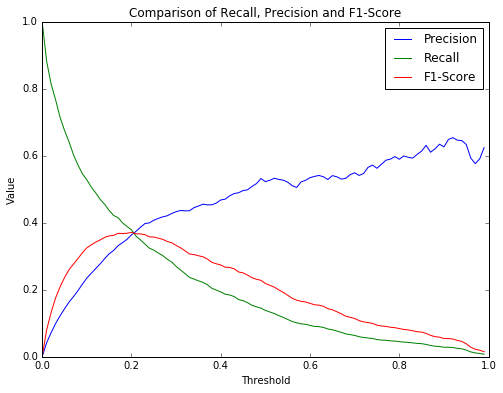

In [50]:
fig = plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.title("Comparison of Recall, Precision and F1-Score")
plt.legend(['Precision', 'Recall', 'F1-Score'])

# Conclusion

State-of-the-art tools can get an F1-Score of about 60% on this dataset. In this notebook, our best F1-Score is closer to 40%. Look at some examples of errors (both False Positives and False Negatives) and think about what went wrong.

### There are several ways we might improve our simple classifier, including:
* Using additional attributes
* Performing better featurization of our textual data (e.g., stemming, n-grams, etc.)
* Using different similarity functions